# Mask R-CNN
## Entrenamiento con clases custom

In [1]:
import cv2
import json
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [2]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

Tenemos que tener nuestras imágenes etiquetadas con las máscaras correspondientes a cada clase. Esto es un proceso tedioso que puede realizarse utilizando programas de etiquetado de imágenes como `labelme`. Muy similar a `labelImg`, usado para etiquetar bounding boxes.

In [3]:
masks_dir = 'custom_masks'

In [4]:
with open(os.path.join(masks_dir, '20230520_173400.json')) as fp:
    mask_data = json.load(fp)

Luego de anotar las imágenes, se genera un json para cada una conteniendo los polígonos correspondientes a cada clase en la imágen. Deberemos hacer el procesamiento correspondiente para generar las máscaras y las bounding boxes para cada instancia.

In [5]:
mask_data

{'version': '5.2.1',
 'flags': {},
 'shapes': [{'label': 'mosqueton',
   'points': [[2039.0833333333335, 2807.6666666666665],
    [2289.0833333333335, 3203.5],
    [2434.916666666667, 3311.8333333333335],
    [2530.75, 3303.5],
    [2634.916666666667, 3182.6666666666665],
    [2618.25, 3061.8333333333335],
    [2526.583333333334, 2557.6666666666665],
    [2468.25, 2470.1666666666665],
    [2326.5833333333335, 2416.0],
    [2218.25, 2432.6666666666665],
    [2089.0833333333335, 2495.1666666666665],
    [2059.916666666667, 2557.6666666666665],
    [2009.916666666667, 2703.5]],
   'group_id': None,
   'description': '',
   'shape_type': 'polygon',
   'flags': {}},
  {'label': 'mosqueton',
   'points': [[580.75, 2103.5],
    [651.5833333333335, 2532.6666666666665],
    [818.25, 2636.8333333333335],
    [1072.416666666667, 2653.5],
    [1139.0833333333335, 2574.3333333333335],
    [1114.0833333333335, 2416.0],
    [859.916666666667, 1924.3333333333333],
    [780.75, 1899.3333333333333],
   

In [6]:
class2idx = {
    '__background__': 0,
    'mosqueton': 1,
    'mate': 2
}

idx2class = {v:k for k, v in class2idx.items()}

In [7]:
def points2maks(points, w, h):
    """Recibe un listado de puntos que definen un polígono y crea una máscara con las dimensiones de la imágen (w y h)"""
    mask = np.zeros(shape=(h, w))
    cv2.fillConvexPoly(
        img=mask, 
        points=np.array(points, dtype='int32'),
        color=1
    )
    return mask

In [8]:
def points2bbox(points):
    """Devuelve la bbox que abarca la máscara en formato [x, y, x+w, y+h]."""
    x, y, w, h = cv2.boundingRect(np.array(points, dtype='int32'))
    bbox = [x, y, x+w, y+h]
    return bbox

In [9]:
def annotations2targets(annotations, class2idx=class2idx):
    """Recibe un json con anotaciones y genera las etiquetas, máscaras y bboxes"""
    image_h = annotations['imageHeight']
    image_w = annotations['imageWidth']
    
    labels = []
    masks = []
    bboxes = []
    
    for object in annotations['shapes']:
        label = class2idx.get(object['label'], 0) # Si no se encuentra la etiqueta en el diccionario, defaultea a 0
        mask = points2maks(object['points'], w=image_w, h=image_h)
        bbox = points2bbox(object['points'])

        labels.append(label)
        masks.append(mask)
        bboxes.append(bbox)

    return {
        'labels': torch.Tensor(labels).to(torch.int64),
        'masks': torch.Tensor(np.array(masks)),
        'boxes': torch.Tensor(bboxes)
    }

In [10]:
annotations = annotations2targets(mask_data)
annotations

{'labels': tensor([1, 1, 1, 1, 1, 1]),
 'masks': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
 

Nuevamente, crearemos una clase custom que herede de Dataset y que implemente los métodos `__len__` y `__getitem__` para obtener las imágenes con sus respectivos targets

In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_dir, classes, transforms=None):
        super().__init__()
        self.annotations_dir = annotations_dir
        self.annotations = [file for file in os.listdir(annotations_dir) if file.endswith('json')]
        self.transforms = transforms
        self.classes = classes

    def __len__(self):
        return len(self.annotations)


    def __getitem__(self, idx):
        # Seleccionamos el archivo con las anotaciones en base al índice
        annotation_file = self.annotations[idx]
        
        with open(os.path.join(self.annotations_dir, annotation_file)) as fp:
            annotation = json.load(fp)

        # Abrimos la imágen de la ruta indicada
        img_path = annotation['imagePath']
        img = np.array(Image.open(os.path.join(self.annotations_dir, img_path)))

        # Procesamos las anotaciones de la imágen
        targets = annotations2targets(annotation, self.classes)

        # Aplicamos las transformaciones si es necesario
        # Tanto las máscaras como las bboxes deben modificarse si se modifica la imágen
        if self.transforms:
            augmented = self.transforms(
                image=img, 
                masks=[targets['masks'][i].numpy() for i in range(targets['masks'].shape[0])], 
                bboxes=targets['boxes'].tolist(), 
                labels=targets['labels'].tolist()
            )
            img = augmented['image'].to(torch.float32)
            targets['masks'] = torch.stack(augmented['masks'], dim=0)
            targets['boxes'] = torch.Tensor(augmented['bboxes'])
        else:
            img = torch.Tensor(img).permute(2, 0, 1)
            targets['masks'] = torch.Tensor(targets['masks']) 
            targets['labels'] = torch.Tensor(targets['labels']).to(torch.int64)

            
        return img, targets
            

Ahora vamos a definir las transformaciones que usaremos durante el entrenamiento. Recordemos que inicialmente es conveniente forzar el overfitting de cualquier modelo, por lo que no realizaremos data augmentation en esta instancia ya que sería contraproducente. Sólo haremos un resize.

In [12]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
transform = A.Compose(
    transforms=[
        A.Resize(width=480, height=480),
        ToTensorV2()
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=['labels']),
)

In [13]:
image = np.array(Image.open(os.path.join('custom_masks/', '../../CV1/YOLOv8/data/train/images/20230520_173400.jpg')))

Instanciamos un `Custom Dataset` y probamos si todo funciona correctamente

In [16]:
data = CustomDataset('custom_masks', class2idx, transforms=transform)

In [17]:
# Tenemos sólo 2 archivos en el directorio
len(data)

2

In [18]:
x, y = data.__getitem__(0)

In [19]:
x.shape

torch.Size([3, 480, 480])

Visualicemos los datos transformados

In [21]:
def plot_training_data(x, y, ax=None):
    if not ax:
        fig, ax = plt.subplots()

    ax.imshow(x.permute(1, 2, 0).to(torch.int))
    
    for i, box in enumerate(y['boxes']):
        # box = box.numpy()
        r = patches.Rectangle(
            xy=(box[0], box[1]),
            width=box[2]-box[0],
            height=box[3]-box[1], 
            facecolor='none',
            linewidth=1,
            edgecolor='r'
        )
        ax.add_patch(r)
        ax.text(
            x=box[0],
            y=box[1],
            s=idx2class[y['labels'][i].item()]
        )

    for i, mask in enumerate(y['masks']):
        ax.imshow(mask, alpha=0.5, vmin=0, vmax=1, cmap='Greys_r')
    

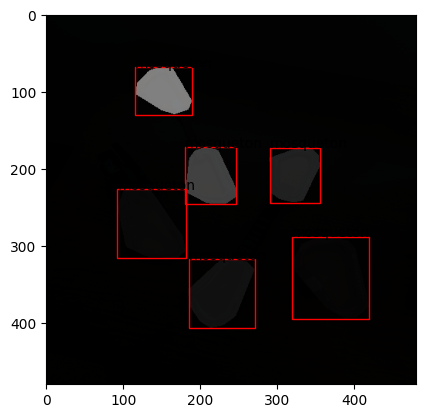

In [22]:
plot_training_data(x, y)

In [23]:
x, y = data.__getitem__(1)

In [24]:
x.shape

torch.Size([3, 480, 480])

In [25]:
y['masks'].shape

torch.Size([1, 480, 480])

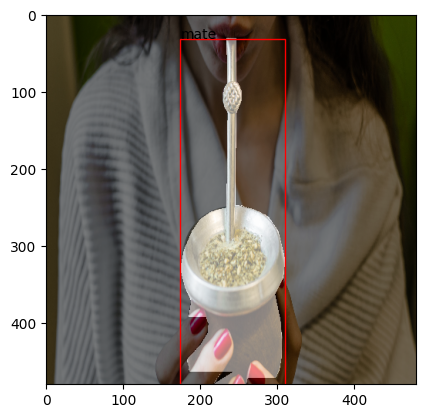

In [26]:
plot_training_data(x, y)

In [27]:
type(y['masks'])

torch.Tensor

## El modelo

Utilizaremos de base una versión pre-entrenada de Mask R-CNN, la cual debemos modificar para que las salidas predigan entre las clases de nuestro dataset y no entre todas las clases de COCO

In [28]:
def get_model_instance_segmentation(num_classes):
    # Cargamos el modelo pre-entrenado con COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # Creamos una nueva salida de clasificación y bboxes, usando las features de la capa anterior
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Reemplazamos el box_predictor con una nueva salida
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Hacemos el mismo proceso con la salida que genera las máscaras
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    # Regresamos el modelo con el backbone pre-entrenado y las salidas para las clases que necesitamos    
    return model

Instanciamos el modelo y lo testeamos

In [29]:
model = get_model_instance_segmentation(num_classes=3)

In [30]:
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
model.eval()
y_hat = model(x)
model.train();

Vemos que en modo evaluación, el modelo genera un diccionario con cada predicción, en la que se encuentran las etiquetas, las máscaras, las bboxes y el score de cada una de ellas

In [31]:
type(y_hat)

list

In [32]:
y_hat[0].keys()

dict_keys(['boxes', 'labels', 'scores', 'masks'])

En modo entrenamiento, el modelo mismo calcula la función de costo para cada tarea

In [33]:
losses = model(x[0].unsqueeze(0), targets=[y])

In [34]:
losses

{'loss_classifier': tensor(1.0426, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0019, grad_fn=<DivBackward0>),
 'loss_mask': tensor(3.8167, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_objectness': tensor(0.1649, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0164, grad_fn=<DivBackward0>)}

## Entrenamiento

Repetiremos el ya conocido loop de entrenamiento, con la salvedad de que en este caso las dimensiones del target dependerán de la cantidad de instancias en cada imágen. Esto hace que no siempre puedan "apilarse" los targets y puede generar problemas en el momento de armar los batches de entrenamiento.

Para prevenir ese problema, debemos reemplazar la función por defecto que usan los DataLoaders para generar los batches por una función custom que no haga stacking de los datos.

In [35]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [36]:
train_loader = torch.utils.data.DataLoader(
    dataset=data,
    batch_size=2,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn
)

In [61]:
def train_fn(loader, model, optimizer, epoch_n=None, eval_metrics=[]):
    """Función que entrena el modelo con todas las imágenes del loader, utilizando el optimizer y calculando la loss_fn"""
    # Inicializamos la loss de esta epoch en 0
    epoch_loss = 0
    # Instanciamos la barra de progreso
    loop = tqdm(loader)
    if epoch_n is not None:
        loop.set_description_str(f"Epoch {epoch_n}")

    # Iteramos por las imágenes del batch
    for batch, (X, y) in enumerate(loop):

        # Reseteamos los gradientes
        optimizer.zero_grad()
        # Llevamos los datos al DEVICE
        X = torch.stack(X, dim=0)
        X = X.to(DEVICE)

        targets = [{k: v.to(DEVICE) for k, v in target.items()} for target in y]
        
        # Procesamos las imágenes
        losses = model(X, targets)
        
        # Calculamos la loss total
        loss = sum(losses.values())
        epoch_loss += loss.item()

        # Calculamos los gradientes y actualizamos los parámetros del modelo
        loss.backward()
        optimizer.step()

        # Calculamos las métricas de evaluación:
        metrics = {'loss': loss.item()}
        for metric in eval_metrics:
            metrics[metric.__name__] = metric(y, y_hat)
        
        loop.set_postfix(**metrics)
        
    # Devolvemos la loss promedio de la epoch
    return epoch_loss/(batch+1)

In [62]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 100

In [63]:
model = model.to(DEVICE)

In [105]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.2e-6)

In [106]:
model.train();
for i in range(EPOCHS):
    train_fn(train_loader, model, optimizer, epoch_n=i+1)

Epoch 100: 100%|███████████████████████| 1/1 [00:00<00:00,  1.23it/s, loss=1.58]


In [117]:
def plot_results(x, y_hat, ax=None):
    if not ax:
        fig, ax = plt.subplots()

    valid_idx = y_hat['scores']>0.8
    y_hat = {
        'boxes': y_hat['boxes'][valid_idx],
        'labels': y_hat['labels'][valid_idx],
        'masks': y_hat['masks'][valid_idx],
    }
    ax.imshow(x.permute(1, 2, 0).to(torch.int))
    
    for i, box in enumerate(y_hat['boxes']):
        box = box.to('cpu')
        r = patches.Rectangle(
            xy=(box[0], box[1]),
            width=box[2]-box[0],
            height=box[3]-box[1], 
            facecolor='none',
            linewidth=1,
            edgecolor='r'
        )
        ax.add_patch(r)
        ax.text(
            x=box[0],
            y=box[1],
            s=idx2class[y_hat['labels'][i].item()]
        )

    for i, mask in enumerate(y_hat['masks']):
        ax.imshow(mask.to('cpu')[0], alpha=0.5, vmin=0, vmax=1, cmap='Greys')

In [118]:
model.eval();
x, _ = data.__getitem__(1)
with torch.no_grad():
    y_hat = model(x.to(DEVICE).unsqueeze(0))

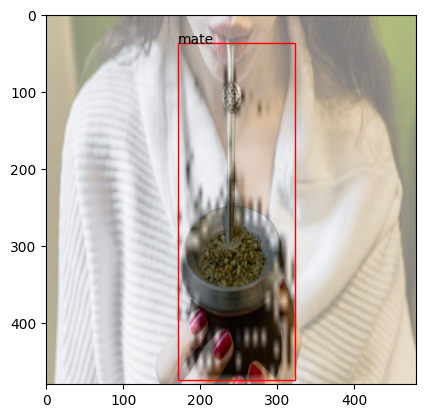

In [119]:
plot_results(x=x, y_hat=y_hat[0])

In [120]:
model.eval();
x, _ = data.__getitem__(0)
with torch.no_grad():
    y_hat = model(x.to(DEVICE).unsqueeze(0))

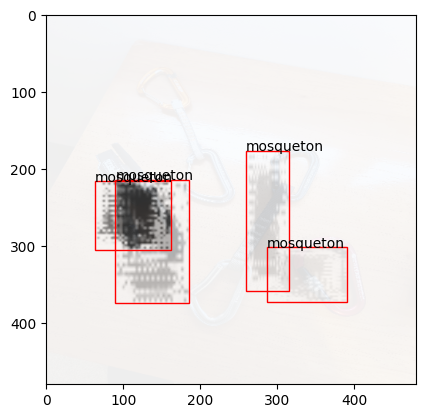

In [121]:
plot_results(x=x, y_hat=y_hat[0])